# Building and visualizing conceptograms

### Imports

In [1]:
import sys
sys.path.insert(0, '/home/saravorabbi/repos/peepholelib') # adapt to your case

In [2]:
# %matplotlib widget

In [3]:
# torch stuff
import torch
import torchvision
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT

# our stuff
from peepholelib.datasets.cifar import Cifar
from peepholelib.models.model_wrap import ModelWrap 
from peepholelib.coreVectors.coreVectors import CoreVectors 
from peepholelib.coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from peepholelib.classifier.classifier_base import trim_corevectors#, map_labels
from peepholelib.classifier.tkmeans import KMeans as tKMeans 
from peepholelib.classifier.tgmm import GMM as tGMM 
from peepholelib.peepholes.peepholes import Peepholes
from peepholelib.utils.testing import trim_dataloaders

# python stuff
import pandas as pd

In [4]:
from nb_utils import *

### GPU check

In [5]:
use_cuda = torch.cuda.is_available()
cuda_index = 0
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(device)

cuda:0


### Path + utils

In [6]:
verbose = True
seed = 42
bs = 512

In [7]:
dataset = 'CIFAR100' 
ds_path = f'/srv/newpenny/dataset/{dataset}'

model_dir = '/srv/newpenny/XAI/models'
model_name = 'SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'


fold = 'vit_1'

svd_path = f'/home/saravorabbi/Documents/{fold}'
svd_name = 'svd'

cvs_path = Path(f'/home/saravorabbi/Documents/{fold}/corevectors')
cvs_name = 'corevectors'


cls_type = 'tGMM'

superclass = False

In [8]:
phs_name = 'peepholes'
phs_path = '/home/saravorabbi/Desktop/new_ph_superclass'

In [9]:
def get_st_list(state_dict):
    '''
    Return a clean list of the layers of the model

    Args:
    - state_dict: state dict of the model

    Return:
    - st_sorted: list of the name of the layers 
    '''
    print('getting all the layers we want')
    state_dict_list = list(state_dict)

    # remove .weight and .bias from the strings in the state_dict list
    st_clean = [s.replace(".bias", "").replace(".weight", "") for s in state_dict_list]
    st_sorted = sorted(list(set(st_clean)))
    filtered_layers = [layer for layer in st_sorted if 'mlp.0' in layer]# or 
                                                       # 'mlp.3' in layer or 
                                                       # 'heads' in layer]
    print('FILTERED LAYERS = ', filtered_layers)
    return filtered_layers


### Dataset

In [10]:
ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 8, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9e40e48830>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f9e4103a000>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f9e40e49e50>}

In [11]:
ds._classes

{0: 'apple',
 1: 'aquarium_fish',
 2: 'baby',
 3: 'bear',
 4: 'beaver',
 5: 'bed',
 6: 'bee',
 7: 'beetle',
 8: 'bicycle',
 9: 'bottle',
 10: 'bowl',
 11: 'boy',
 12: 'bridge',
 13: 'bus',
 14: 'butterfly',
 15: 'camel',
 16: 'can',
 17: 'castle',
 18: 'caterpillar',
 19: 'cattle',
 20: 'chair',
 21: 'chimpanzee',
 22: 'clock',
 23: 'cloud',
 24: 'cockroach',
 25: 'couch',
 26: 'crab',
 27: 'crocodile',
 28: 'cup',
 29: 'dinosaur',
 30: 'dolphin',
 31: 'elephant',
 32: 'flatfish',
 33: 'forest',
 34: 'fox',
 35: 'girl',
 36: 'hamster',
 37: 'house',
 38: 'kangaroo',
 39: 'keyboard',
 40: 'lamp',
 41: 'lawn_mower',
 42: 'leopard',
 43: 'lion',
 44: 'lizard',
 45: 'lobster',
 46: 'man',
 47: 'maple_tree',
 48: 'motorcycle',
 49: 'mountain',
 50: 'mouse',
 51: 'mushroom',
 52: 'oak_tree',
 53: 'orange',
 54: 'orchid',
 55: 'otter',
 56: 'palm_tree',
 57: 'pear',
 58: 'pickup_truck',
 59: 'pine_tree',
 60: 'plain',
 61: 'plate',
 62: 'poppy',
 63: 'porcupine',
 64: 'possum',
 65: 'rabbit',

### Model wrap

These are the layers that compose the conceptograms, to which we may or may not add the softmax output of the DNN:

In [12]:
n_classes = len(ds.get_classes()) 
n_classes

100

In [13]:
nn = torchvision.models.vit_b_16()
in_features = nn.heads.head.in_features
nn.heads.head = torch.nn.Linear(in_features, n_classes)

wrap = ModelWrap(device=device)
wrap.set_model(
    model = nn,
    path = model_dir,
    name = model_name
)

/home/saravorabbi/repos/peepholelib/peepholelib/models/model_wrap.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self

In [14]:
# get all target layers with the function defined in utils section
target_layers = get_st_list(nn.state_dict().keys())

getting all the layers we want
FILTERED LAYERS =  ['encoder.layers.encoder_layer_0.mlp.0', 'encoder.layers.encoder_layer_1.mlp.0', 'encoder.layers.encoder_layer_10.mlp.0', 'encoder.layers.encoder_layer_11.mlp.0', 'encoder.layers.encoder_layer_2.mlp.0', 'encoder.layers.encoder_layer_3.mlp.0', 'encoder.layers.encoder_layer_4.mlp.0', 'encoder.layers.encoder_layer_5.mlp.0', 'encoder.layers.encoder_layer_6.mlp.0', 'encoder.layers.encoder_layer_7.mlp.0', 'encoder.layers.encoder_layer_8.mlp.0', 'encoder.layers.encoder_layer_9.mlp.0']


In [15]:
wrap.set_target_layers(target_layers=target_layers)

### Corevectors and labels



In [16]:
cv_dict = {}
result = {}
pred = {}
true = {}

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        device = device 
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            )

    cv_dl = cv.get_dataloaders(
                batch_size=256,
                verbose=True,
                )

    for split in ['train', 'test', 'val']:
        result[split] = cv_dl[split].dataset['result'].detach().cpu().numpy()
        pred[split] = cv_dl[split].dataset['pred'].detach().cpu().numpy()
        true[split] = cv_dl[split].dataset['label'].detach().cpu().numpy()
    
        # cv_dict[split] = cv_dl[split].dataset['coreVectors'].detach().cpu().numpy()


 ---- Getting data from train

File /home/saravorabbi/Documents/vit_1/corevectors/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /home/saravorabbi/Documents/vit_1/corevectors/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /home/saravorabbi/Documents/vit_1/corevectors/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
closing train
closing test
closing val


### NN Outputs
Now we collect the outputs of the model and store its evaluation results into a dictionary made of `pd.DataFrame`.

In [17]:
nn_ = nn
_ = nn_.eval()

In [18]:
splits = ['train', 'val', 'test']

In [19]:
o_dnn = {}      # structure to store DNN outputs (you will need them for the conceptograms)
o_dnn_dfs = {}  # here you can store pd.DataFrame to evaluate the NN

for split in splits:
    if split=='train':
        data_loader = ds.get_train_dataset()
    elif split=='val':
        data_loader = ds.get_val_dataset()
    elif split=='test':
        data_loader = ds.get_test_dataset()

    outputs_ = []
    
    correct_predictions = 0
    total_predictions = 0
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for data in tqdm(data_loader):  # data is a batch
            inputs, targets = data
            true_labels.append(targets)
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = nn_(inputs)
            outputs_.append(outputs)
    
            _, predicted = torch.max(outputs, 1)
            pred_labels.append(predicted.cpu())
            
            correct_predictions += accuracy(outputs, targets) * targets.size(0)
            total_predictions += targets.size(0)
    
    outputs = torch.nn.functional.softmax(torch.cat(outputs_), dim=1)
    outputs = outputs.detach().cpu().numpy()

    o_dnn[split] = outputs # output collection

    # output processing
    pred_labels = torch.concatenate(pred_labels)
    true_labels = torch.concatenate(true_labels)
    r = pred_labels==true_labels

    out_max = np.max(outputs, axis=1)
    out_label = np.argmax(outputs, axis=1)

    out_df = pd.DataFrame()
    out_df['max'] = out_max # use it for confidence
    out_df['entropy'] = [1 - normalized_entropy(out, adjusted=False) for out in outputs]
    out_df['label'] = out_label
    out_df['true'] = true_labels #true
    out_df['true'] = out_df['true'].astype(int)
    out_df['result'] = r

    o_dnn_dfs[split] = out_df # performance results collection

100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


### Load peepholes

In [20]:
results_dir = Path('/home/saravorabbi/Desktop/results_conceptogram_superclass')    # use a directory to store results
results_dir.mkdir(parents=True, exist_ok=True)

In [21]:
cls_type = 'tGMM'
splits = ['train', 'test', 'val']

In [22]:
# peephole_config_name = 'peepholes.200.150'
peephole_config_name = 'peepholes.200.10'

In [23]:
config_names = {'peepholes.200.10'}
config_names


{'peepholes.200.10'}

In [24]:
# load scores
ph_dict = {}
for ph_config_name in config_names:
    peepholes = Peepholes(
        path=phs_path,
        name=ph_config_name,
        classifier=None,
        layer=target_layers,
        device=device
    )
    with peepholes as ph:
        ph.load_only(loaders=splits, verbose=False)
        for split in splits:
            ph_dict.setdefault(ph_config_name, {})[split] = ph._phs[split].detach().cpu()

closing train
closing test
closing val


### Mapping logits & model output functions

In [25]:
mapping_dir = '/srv/newpenny/XAI/models/superclass_mapping_CIFAR100.pkl'

with open(Path(mapping_dir), 'rb') as f:
    mapping_dict = pickle.load(f)


In [26]:
len(mapping_dict)

20

In [27]:
mapping_dict

{0: [4, 30, 55, 72, 95],
 1: [1, 32, 67, 73, 91],
 2: [54, 62, 70, 82, 92],
 3: [9, 10, 16, 28, 61],
 4: [0, 51, 53, 57, 83],
 5: [22, 39, 40, 86, 87],
 6: [5, 20, 25, 84, 94],
 7: [6, 7, 14, 18, 24],
 8: [3, 42, 43, 88, 97],
 9: [12, 17, 37, 68, 76],
 10: [23, 33, 49, 60, 71],
 11: [15, 19, 21, 31, 38],
 12: [34, 63, 64, 66, 75],
 13: [26, 45, 77, 79, 99],
 14: [2, 11, 35, 46, 98],
 15: [27, 29, 44, 78, 93],
 16: [36, 50, 65, 74, 80],
 17: [47, 52, 56, 59, 96],
 18: [8, 13, 48, 58, 90],
 19: [41, 69, 81, 85, 89]}

In [28]:
val = 89

key = next((k for k, v in mapping_dict.items() if val in v), None)

print(key)  # Output: 10


19


In [29]:
superclass_names = [
    "Aquatic Mammals", "Fish", "Flowers", "Food Containers", "Fruit and Vegetables",
    "Household Electrical Devices", "Household Furniture", "Insects", "Large Carnivores", "Large Man-made Outdoor Things",
    "Large Natural Outdoor Scenes", "Large Omnivores and Herbivores", "Medium-sized Mammals", "Non-insect Invertebrates",
    "People", "Reptiles", "Small Mammals", "Trees", "Vehicles 1", "Vehicles 2"
]

In [30]:
# function that maps the logit
def map_number(cifar_class):
    
    superclass = next((k for k, v in mapping_dict.items() if cifar_class in v), None)
    
    return superclass


# map of the output of the net to the superclasses
def map_out_net(out_net):
    
    super_out = np.zeros(20)

    for key, indices in mapping_dict.items():
        super_out[key] = np.sum(out_net[indices])
    
    return super_out

### Store all Conceptogram

Remember that peephole_config_name = 'peepholes.200.50'

DS_KEY  -> mmTtensor Dict  
size del memory mapped tensor: n elementi test ds + n target layers + 100 (classi di CIFAR 100 -> 20 se superclassi)

In [31]:
# cgs_dict is the dict that contains all conceptograms matrices that we are going to print
cgs_dict = {}
layer = list(ph_dict[peephole_config_name]['train'].keys())[0]

# create the memory mapped tensor dict (pre allocating memory, very mindful)
for key in ph_dict[peephole_config_name].keys():
    cgs_dict[key] = MMT.empty(shape=torch.Size((len(ph_dict[peephole_config_name][key][layer]['peepholes']),)+(len(ph_dict[peephole_config_name]['train'].keys()),)+(len(mapping_dict),)))
    print(cgs_dict[key].shape)

torch.Size([40000, 12, 20])
torch.Size([10000, 12, 20])
torch.Size([10000, 12, 20])


In [32]:
ph_dict[peephole_config_name][key][layer]['peepholes'].shape

torch.Size([10000, 20])

In [33]:
# allocating the actual peepholes in the dictionary
for key in ph_dict[peephole_config_name].keys():
    print(f'\n------------{key}-------------')
    for i,layer in enumerate(target_layers):
        cgs_dict[key][:,i,:] = ph_dict[peephole_config_name][key][layer]['peepholes']
        print(cgs_dict[key][0])


------------train-------------
MemoryMappedTensor([[0.0269, 0.0362, 0.1584, 0.0197, 0.0949, 0.0148, 0.0252,
                     0.0953, 0.0987, 0.0117, 0.0314, 0.0611, 0.0580, 0.0404,
                     0.0235, 0.0501, 0.0625, 0.0507, 0.0166, 0.0238],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

MemoryMappedTensor([[0.0269, 0.0362, 0.1584, 0.0197, 0.0949, 0.0148, 0.0252,
                     0.0953, 0.0987, 0.0117, 0.0314, 0.0611, 0.0580, 0.0404,
                     0.0235, 0.0501, 0.0625, 0.0507, 0.0166, 0.0238],
                    [0.0139, 0.0260, 0.1895, 0.0353, 0.1488, 0.0254, 0.0661,
                     0.0589, 0.0747, 0.0029, 0.0182, 0.0340, 0.0420, 0.0661,
                     0.0615, 0.0442, 0.0482, 0.0211, 0.0123, 0.0110],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                     0.0000

In [34]:
cgs_dict.keys()

dict_keys(['train', 'test', 'val'])

In [35]:
cgs_dict[split].shape

torch.Size([10000, 12, 20])

In [36]:
cgs_dict[split][0].shape

torch.Size([12, 20])

### Plot some Conceptograms

In [37]:
split = 'test'

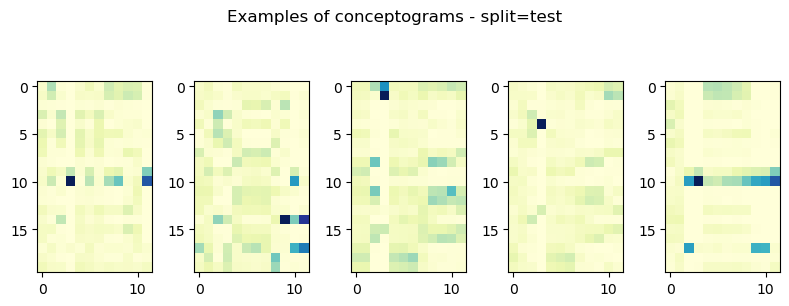

In [38]:
# 5 conceptograms
n_cgs = 5

fig, axs = plt.subplots(1, n_cgs, figsize=(8, 3))
fig.suptitle(f'Examples of conceptograms - split={split}\n')
for i in range(n_cgs):
    axs[i].imshow(cgs_dict[split][i].detach().cpu().numpy().T, cmap='YlGnBu')
    
plt.tight_layout()
plt.show()

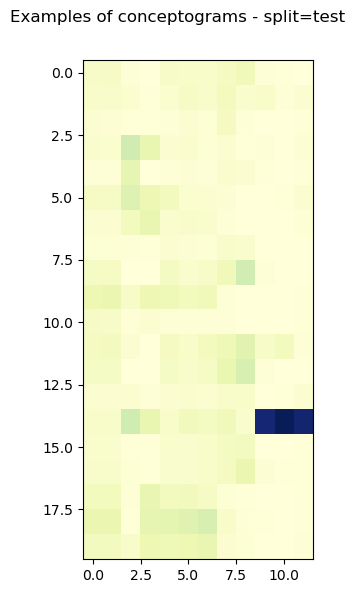

In [39]:
# just one
split = 'test'

n_cgs = 7000

fig, axs = plt.subplots(1, 1, figsize=(3, 6))
fig.suptitle(f'Examples of conceptograms - split={split}\n')
axs.imshow(cgs_dict[split][n_cgs].detach().cpu().numpy().T, aspect='auto', cmap='YlGnBu')
    
plt.tight_layout()
plt.show()

### Concepto with output

In [40]:
# Assuming o_dnn['test'][sample] is your array
array = o_dnn['test'][0]  # Replace this with your actual data

# Get the maximum value and its position
max_value = np.max(array)
max_position = np.argmax(array)


In [41]:
print(f"Max value: {max_value}")
print(f"Position of max value: {max_position}")

Max value: 0.8857045769691467
Position of max value: 68


We need 
- true label
- pred label

La **pred label** la prendiamo da `o_dnn`, il dizionario con tutti gli output predetti

La **true label** la prendiamo da dove? Da `odnn_dfs` :)

In [42]:
o_dnn['test'].shape
o_dnn_dfs['test']

,max,entropy,label,true,result
0,0.885705,0.861957,68,49,False
1,0.527430,0.682829,46,33,False
2,0.838354,0.848392,72,72,True
3,0.982981,0.965217,51,51,True
4,0.685359,0.831165,71,71,True
...,...,...,...,...,...
9995,0.855758,0.875492,0,83,False
9996,0.990154,0.981721,14,14,True
9997,0.974796,0.952896,51,51,True
9998,0.995056,0.989084,42,42,True


In [43]:
o_dnn_dfs['test'].keys()

Index(['max', 'entropy', 'label', 'true', 'result'], dtype='object')

In [44]:
print(o_dnn_dfs['test']['label'][0])
print(o_dnn_dfs['test']['true'][0])
print(o_dnn_dfs['test']['result'][0])

# mapping
print(ds._classes[o_dnn_dfs['test']['label'][0]])   # to be mapped
print(ds._classes[o_dnn_dfs['test']['true'][0]])    # to be mapped
print(ds._classes[o_dnn_dfs['test']['result'][0]])


68
49
False
road
mountain
apple


In [45]:
sample = 1568
#777

# labels
true_out = o_dnn_dfs[split]['true'][sample]     # number
true_class = ds._classes[true_out]              # string
true_out_sup = map_number(true_out)

print('Class true out: \t', true_out)
print('Superclass true out: \t', true_out_sup)
print('Superclass true label: \t',superclass_names[true_out_sup])


Class true out: 	 58
Superclass true out: 	 18
Superclass true label: 	 Vehicles 1


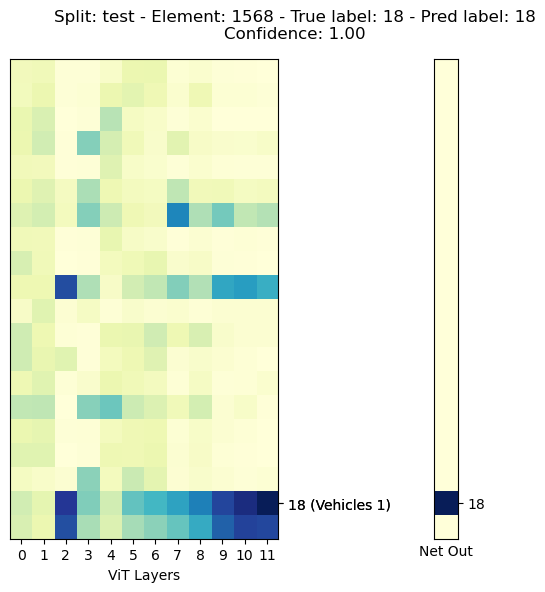

In [46]:
# finally plot a conceptogram with superclasses

split = 'test'

sample = 1568
#777

# labels
true_out = map_number(o_dnn_dfs[split]['true'][sample])     # number
true_class = superclass_names[true_out]                     # string

label_out = map_number(o_dnn_dfs[split]['label'][sample])
label_class = superclass_names[label_out]

confidence = o_dnn_dfs[split]['max'][sample]

# matrix and array (print pre label with soft max -> o_dnn)
concepto = cgs_dict[split][sample].detach().cpu().numpy().T
out_net = map_out_net(o_dnn[split][sample])             # roba predetta
out_net = np.expand_dims(out_net, axis=1)



fig, ax = plt.subplots(1, 2, figsize=(6,6))
fig.suptitle(f'Split: {split} - Element: {sample} - True label: {true_out} - Pred label: {label_out}\nConfidence: {confidence:.2f}')

ax[0].imshow(concepto, aspect='auto', cmap='YlGnBu')
ax[0].set_xticks(np.arange(12))
ax[0].set_yticks([true_out, label_out], [f'{true_out} ({true_class})', f'{label_out} ({label_class})'])
ax[0].yaxis.tick_right()
ax[0].set_xlabel('ViT Layers')

ax[1].imshow(out_net, cmap='YlGnBu')
ax[1].set_xticks([])
ax[1].set_yticks([true_out])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_xlabel('Net Out') # carino? forse si può levare

plt.tight_layout()
plt.show()

In [47]:
# cycle that prints the first 5 config 

rand_samples = []

cifar_class = 8
result = 0
confidence = 0.9


i = 0
while len(rand_samples) <= 5 and i < 10000:
    if o_dnn_dfs[split]['result'][i] == result and o_dnn_dfs[split]['true'][i] == cifar_class:# and o_dnn_dfs[split]['max'][i] >= confidence:
        rand_samples.append(i)
    i = i + 1
print(i)
print(rand_samples)
print(ds._classes[cifar_class])

10000
[1094, 2147, 6799, 9425]
bicycle


In [48]:
rand_samples = [2, 4, 78, 123, 341]

# Sort indices based on confidence values in descending order
sorted_samples = sorted(rand_samples, key=lambda sample: o_dnn_dfs[split]['max'][sample], reverse=True)

print(sorted_samples)

[78, 341, 2, 4, 123]


In [49]:
for i, sample in enumerate(sorted_samples):
    confidence = o_dnn_dfs[split]['max'][sample]
    print(confidence)

0.971738
0.9673806
0.8383542
0.68535906
0.5477469


### #TODO fix functions for superclasses

In [50]:
def generate_concepto(number, cifar_class, result, confidence):
    '''
    Generate a specified number of conceptograms ordered by confidence - from highest to lowest
    
    Args:
    - number (int): number of sample we want to plot
    - cifar_class (str): CIFAR100 class we want to plot
    - result (0 or 1): 0 if the net guess the wrong label - 1 if the net guess the right label
    - confidence (value in [0,1]): confidence
    
    Returns:
    - a thumbs up
    '''

    split = 'test'

    rand_samples = []
    k = 0
    while len(rand_samples) < number and k < len(o_dnn_dfs[split]): # per il test set specifically
        if o_dnn_dfs[split]['result'][k] == result and o_dnn_dfs[split]['true'][k] == cifar_class and o_dnn_dfs[split]['max'][k] >= confidence:
            rand_samples.append(k)
        k += 1
    
    print(f'Number of samples found is {len(rand_samples)} out of {number}')
    print('Chosen class is : ', ds._classes[cifar_class])

    # order out by confidence
    sorted_samples = sorted(rand_samples, key=lambda sample: o_dnn_dfs[split]['max'][sample], reverse=True)


    for i, sample in enumerate(sorted_samples):
        # labels
        true_out = o_dnn_dfs[split]['true'][sample]     # number
        true_class = ds._classes[true_out]              # string

        label_out = o_dnn_dfs[split]['label'][sample]
        label_class = ds._classes[label_out]

        confidence = o_dnn_dfs[split]['max'][sample]

        # matrix and array (print pre label with soft max -> o_dnn)
        concepto = cgs_dict[split][sample].detach().cpu().numpy().T
        out_net = np.expand_dims(o_dnn[split][sample], axis=1) # roba predetta



        fig, ax = plt.subplots(1, 2, figsize=(6, 8))
        fig.suptitle(f'Split: {split} - Element: {sample} - True label: {true_out} - Pred label: {label_out}\nConfidence: {confidence:.2f}')

        # sub plot concepto
        ax[0].imshow(concepto, aspect='auto', cmap='YlGnBu')
        ax[0].set_xticks(np.arange(12))
        ax[0].set_yticks([true_out, label_out], [f'{true_out} ({true_class})', f'{label_out} ({label_class})'])
        ax[0].yaxis.tick_right()
        ax[0].set_xlabel('ViT Layers')
        
        # sub plot out rete
        ax[1].imshow(out_net, cmap='YlGnBu')
        ax[1].set_xticks([])
        ax[1].set_yticks([true_out])
        ax[1].yaxis.set_label_position("right")
        
        ax[1].yaxis.tick_right()
        ax[1].set_xlabel('Net Out')

        plt.tight_layout()
        plt.show()
    
    return

Number of samples found is 5 out of 1000
Chosen class is :  apple


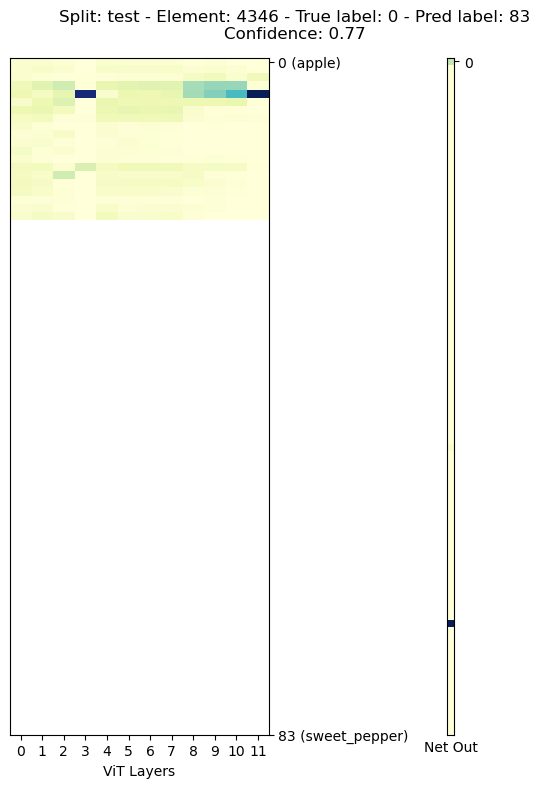

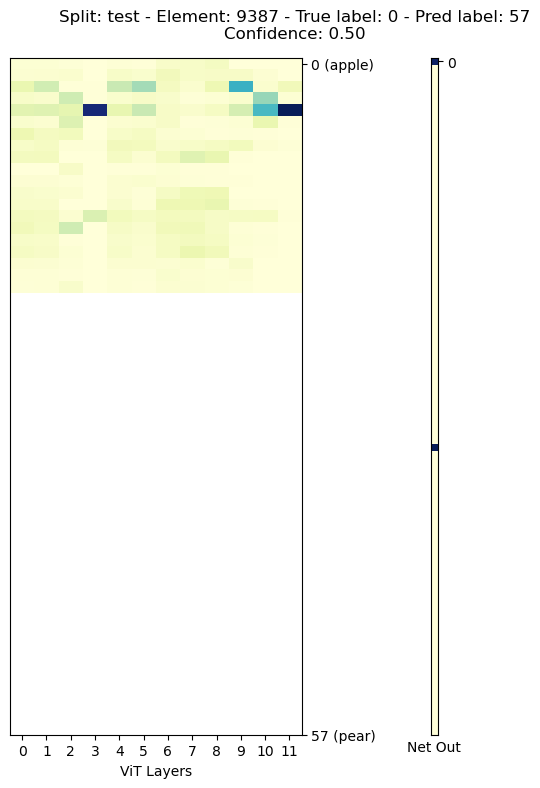

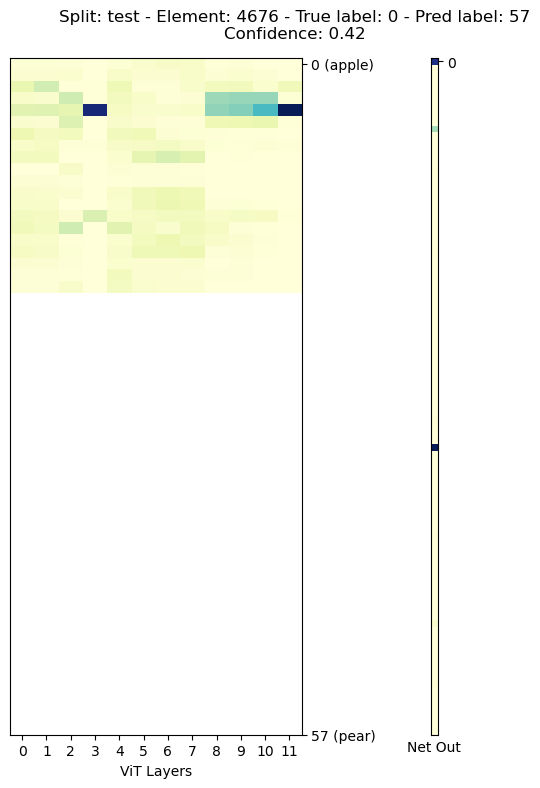

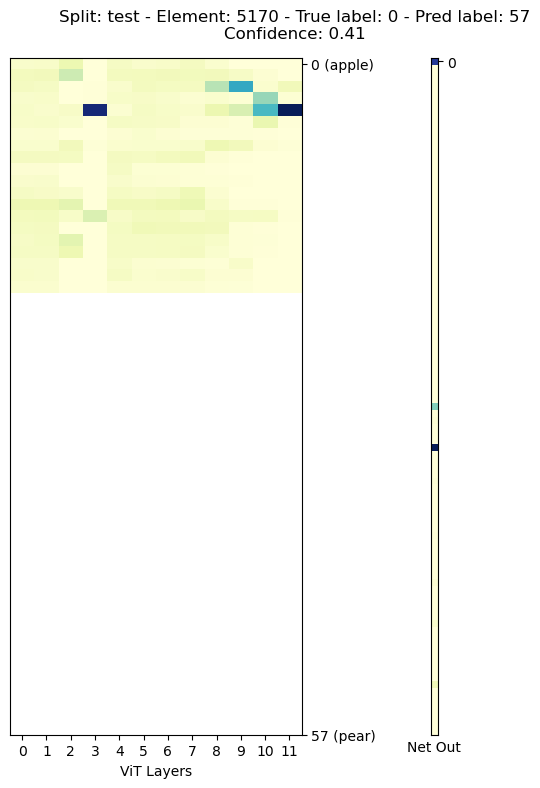

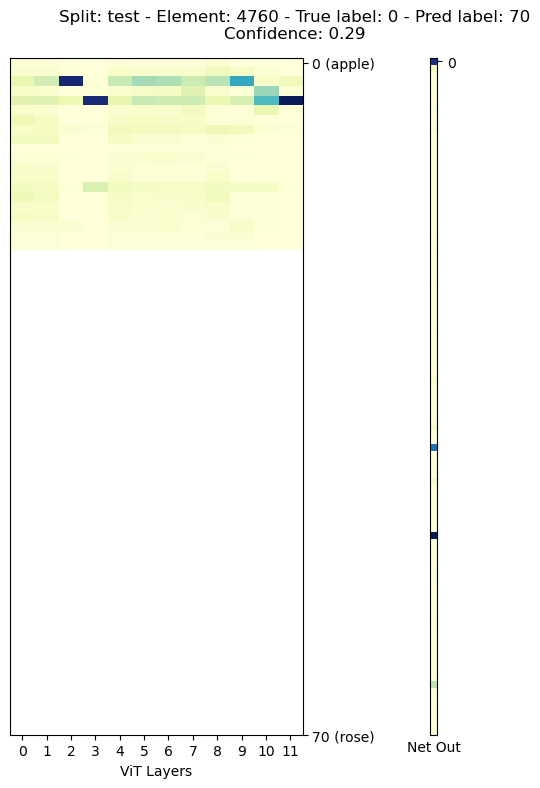

In [51]:
number = 1000
cifar_class = 0
result = 0
confidence = 0

generate_concepto(number, cifar_class, result, confidence)

In [52]:
def generate_5_concepto_horiz(cifar_class, result, confidence):
    
    split = 'test'

    rand_samples = []
    k = 0
    while len(rand_samples) < 5:
        if o_dnn_dfs[split]['result'][k] == result and o_dnn_dfs[split]['true'][k] == cifar_class and o_dnn_dfs[split]['max'][k] >= confidence:
            rand_samples.append(k)
        k += 1

    print('Samples found: ', rand_samples)

    print('Chosen class:', ds._classes[cifar_class])

    fig, axes = plt.subplots(1, 10, figsize=(30, 10))  # 1 row and 10 columns (10 subplots in a row)

    for i, sample in enumerate(rand_samples):
        
        # labels
        true_out = o_dnn_dfs[split]['true'][sample] # number
        true_class = ds._classes[true_out]          # string

        label_out = o_dnn_dfs[split]['label'][sample]
        label_class = ds._classes[label_out]

        confidence = o_dnn_dfs[split]['max'][sample]

        # matrix and array (print pre label with soft max -> o_dnn)
        concepto = cgs_dict[split][sample].detach().cpu().numpy().T
        out_net = np.expand_dims(o_dnn[split][sample], axis=1)  # roba predetta

        # conceptogram plot (Odd indices: 0, 2, 4, 6, 8)
        ax_concepto = axes[i * 2]
        ax_concepto.imshow(concepto, aspect='auto', cmap='YlGnBu')
        ax_concepto.set_xticks(np.arange(12))
        ax_concepto.set_yticks([true_out, label_out], [f'{true_out} ({true_class})', f'{label_out} ({label_class})'])
        ax_concepto.yaxis.tick_right()
        ax_concepto.set_xlabel('ViT Layers')
        ax_concepto.set_title(f'Element: {sample}\nConfidence: {confidence:.2f}')

        # net output plot (Even indices: 1, 3, 5, 7, 9)
        ax_out_net = axes[i * 2 + 1]
        ax_out_net.imshow(out_net, cmap='YlGnBu')
        ax_out_net.set_xticks([])
        ax_out_net.set_yticks([true_out])
        ax_out_net.yaxis.set_label_position("right")
        ax_out_net.yaxis.tick_right()
        ax_out_net.set_xlabel('Net Out')

    # global title
    fig.suptitle(f'Split: {split} - Class: {cifar_class} ({ds._classes[cifar_class]})', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()


woman
Samples found:  [2870, 4247, 5545, 6021, 7059]
Chosen class: woman


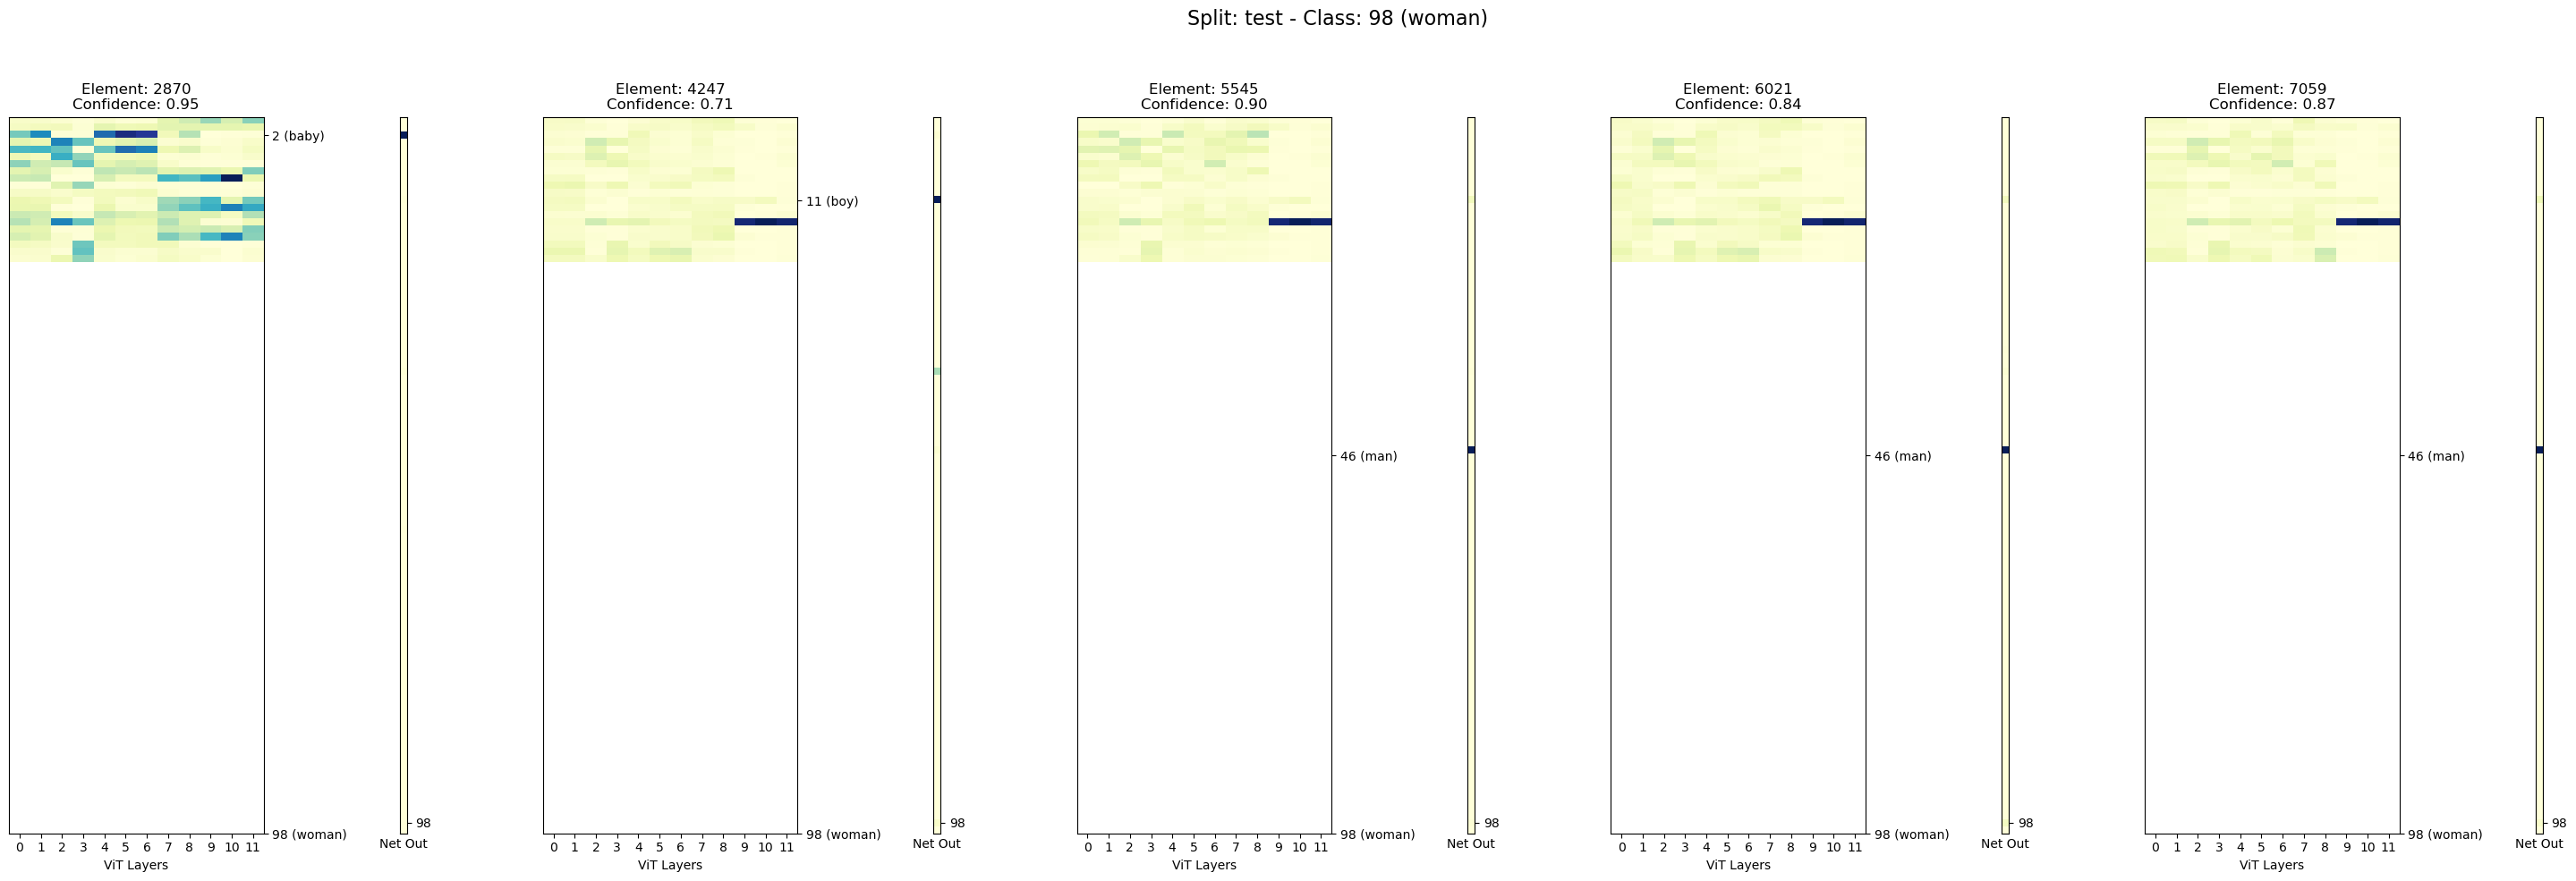

In [53]:
cifar_class = 98
result = 0
confidence = 0.7

print(ds._classes[cifar_class])

generate_5_concepto_horiz(cifar_class, result, confidence)